In [1]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [4]:
from PIL import Image
from glob import glob

In [5]:
data_path = "/content/drive/MyDrive/smoke"

In [6]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [7]:
# Example usage:
train_path = data_path + '/Training/Training/'
valid_path = data_path + '/Validation/Validation/'
test_path = data_path + '/Testing/Testing/'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [8]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


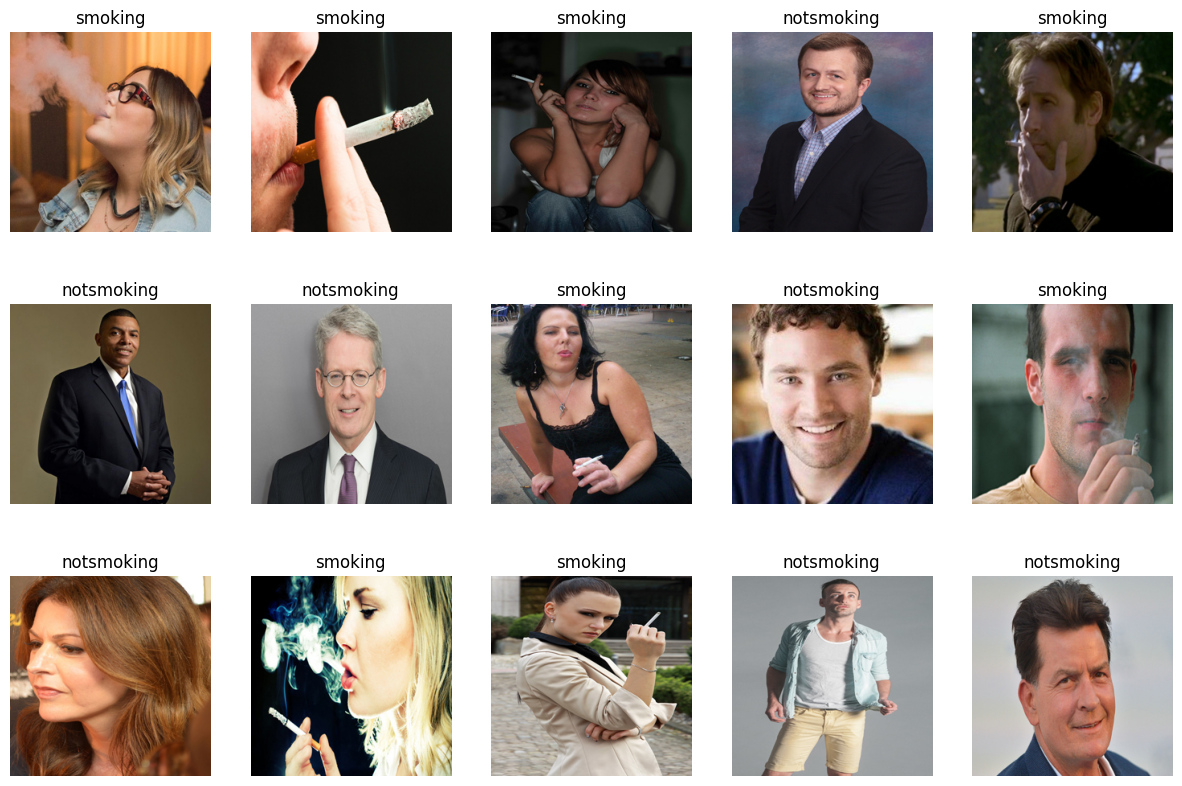

In [9]:
show_imgs = 15 # 랜덤 이미지 15장
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10)) # 15/5 = 3, 3*5행열 subplot 생성
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [10]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [11]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [12]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) # dtype 변환

In [13]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [14]:
img, class_id = next(iter(example_dataset)) # 이미지, 레이블을 꺼내오는 코드, 한 장을 꺼냄

In [15]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [16]:
img, class_id = next(iter(example_loader)) # 배치 하나를 꺼냄

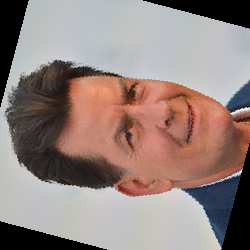

In [17]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


In [18]:
# 변경 가능하시만, Plain CNN, MyResnet, Pretrained Resent 모두 동일하게 사용하세요.

CustomTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [19]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

# 문제 1 (15점)

- 해당 조건에 맞게 CNN Model을 구성하고 Smoke dataset에 대해서 성능 평가(Acc, F1)를 진행하시오.
- early stopping을 사용하여 overfitting을 방지하고, learning curve를 시각화하시오.
- Loss function으로 `nn.BCELoss()` 사용하세요. (아닐 시 감점)


| Stage | Layer (Block 이름)  | Output Size           | Kernel Size / Stride             | Channels | Conv Layers in Block |
| ----- | ----------------- | --------------------- | -------------------------------- | -------- | ----------- |
| 0     | Conv Block 1      | 224 × 224 → 112 × 112 | Conv Layer(3×3/1) ×2 / MaxPool (2×2 / 2) | 64       | 2           |
| 1     | Conv Block 2      | 112 × 112 → 56 × 56   | Conv Layer(3×3/1) ×2 / MaxPool (2×2 / 2) | 128      | 2           |
| 2     | Conv Block 3      | 56 × 56 → 28 × 28     | Conv Layer(3×3/1) ×3 / MaxPool (2×2 / 2) | 256      | 3           |
| 3     | Conv Block 4      | 28 × 28 → 14 × 14     | Conv Layer(3×3/1) ×3 / MaxPool (2×2 / 2) | 512      | 3           |
| 4     | Conv Block 5      | 14 × 14 → 7 × 7       | Conv Layer(3×3/1) ×3 / MaxPool (2×2 / 2) | 512      | 3           |
| 5     | Flatten           | ?       | -                                | -        | -           |
| 6     | Fully Connected 1 | ? → 4096          | Linear  + ReLU + Dropout                           | 4096     | -           |
| 7     | Fully Connected 2 | 4096 → 1024           | Linear + ReLU + Dropout                         |  1024     | -           |
| 8     | Fully Connected 3 | 1024 → 128           | Linear + ReLU + Dropout                       | 128     | -           |
| 8     | Fully Connected 4 | 128 → 1           | Linear                      | 1     | -           |


### Stage 0 예시


``` python
# Conv Layer 는 Conv - BatchNorm - Relu 구조로 구성됨

Conv_Layer_1 =  nn.Sequential(
            nn.Conv2d(),
            nn.BatchNorm2d(),
            nn.ReLU()
        )

Conv_Layer_2 =  nn.Sequential(
            nn.Conv2d(),
            nn.BatchNorm2d(),
            nn.ReLU()
        )


# Conv Block은 Conv Layer로 구성됨

Conv_block =  nn.Sequential(
        nn.Sequential([Conv_Layer_1, Conv_Layer_2])
        nn.MaxPool2d()
        )


```

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

# ------------------------------------------------------------
# 문제 1 ― Plain CNN
# ------------------------------------------------------------
class PlainCNN(nn.Module):

    def __init__(self):
        super(PlainCNN,self).__init__()

        # Conv Block 1: 3 -> 64, 2 convs
        self.block1 = self._make_block(3, 64, num_convs=2)

        # Conv Block 2: 64 -> 128, 2 convs
        self.block2 = self._make_block(64, 128, num_convs=2)

        # Conv Block 3: 128 -> 256, 3 convs
        self.block3 = self._make_block(128, 256, num_convs=3)

        # Conv Block 4: 256 -> 512, 3 convs
        self.block4 = self._make_block(256, 512, num_convs=3)

        # Conv Block 5: 512 -> 512, 3 convs
        self.block5 = self._make_block(512, 512, num_convs=3)

        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc4 = nn.Linear(128, 1)

    def _make_block(self, in_channels, out_channels, num_convs):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x


In [42]:
# Traninig

EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()
model = PlainCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Cosine_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


patience = 10
counter = 0
best_loss = np.inf

def train(dataloader , model , loss_fn , optimizer , lr_scheduler):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        output = model(data_)
        loss = loss_fn(output, target_.unsqueeze(1).float()) # BCELoss는 (Batch, 1) 형태
        loss.backward()
        optimizer.step()

        pred = (output > 0.5).float()
        epoch_correct += (pred == target_.unsqueeze(1)).sum().item()
        epoch_loss += loss.item()
        size += target_.size(0)
        #===================================================#

    train_acc = epoch_correct/size
    lr_scheduler.step()

    return train_acc , epoch_loss / num_batches


def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            data_, target_ = data_.to(device), target_.to(device)
            output = model(data_)
            loss = loss_fn(output, target_.unsqueeze(1).float())

            pred = (output > 0.5).float()
            epoch_correct += (pred == target_.unsqueeze(1)).sum().item()
            epoch_loss += loss.item()
            size += target_.size(0)
            #========================================#

    test_acc = epoch_correct/size

    return test_acc  , epoch_loss / num_baches




for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   model ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , model , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , model , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 3.9821 , train_acc:0.4902     val_loss = 0.7137 , val_acc:0.5000     learning rate: 0.0009755282581475768


  2%|▏         | 2/100 [00:16<13:38,  8.35s/it]

epoch:1     train_loss = 3.9891 , train_acc:0.5112     val_loss = 2.6084 , val_acc:0.5000     learning rate: 0.0009045084971874736


  3%|▎         | 3/100 [00:23<12:38,  7.82s/it]

epoch:2     train_loss = 0.8685 , train_acc:0.5056     val_loss = 0.7255 , val_acc:0.5056     learning rate: 0.0007938926261462366
epoch:3     train_loss = 0.7507 , train_acc:0.5070     val_loss = 0.6914 , val_acc:0.5111     learning rate: 0.0006545084971874737


  5%|▌         | 5/100 [00:40<12:48,  8.08s/it]

epoch:4     train_loss = 0.7172 , train_acc:0.5098     val_loss = 0.7095 , val_acc:0.5000     learning rate: 0.0005
epoch:5     train_loss = 0.6980 , train_acc:0.5112     val_loss = 0.6867 , val_acc:0.5056     learning rate: 0.00034549150281252633


  7%|▋         | 7/100 [00:56<12:26,  8.03s/it]

epoch:6     train_loss = 0.7017 , train_acc:0.5209     val_loss = 0.6879 , val_acc:0.5000     learning rate: 0.0002061073738537635
epoch:7     train_loss = 0.6876 , train_acc:0.5168     val_loss = 0.6867 , val_acc:0.5000     learning rate: 9.549150281252634e-05


  8%|▊         | 8/100 [01:04<12:23,  8.08s/it]

epoch:8     train_loss = 0.6829 , train_acc:0.5251     val_loss = 0.6860 , val_acc:0.5111     learning rate: 2.4471741852423235e-05


 10%|█         | 10/100 [01:22<12:41,  8.47s/it]

epoch:9     train_loss = 0.6886 , train_acc:0.5182     val_loss = 0.6865 , val_acc:0.5167     learning rate: 0.0


 11%|█         | 11/100 [01:29<11:57,  8.06s/it]

epoch:10     train_loss = 0.6889 , train_acc:0.5433     val_loss = 0.6870 , val_acc:0.5167     learning rate: 2.4471741852423235e-05


 12%|█▏        | 12/100 [01:36<11:27,  7.81s/it]

epoch:11     train_loss = 0.6808 , train_acc:0.5154     val_loss = 0.6871 , val_acc:0.5167     learning rate: 9.549150281252665e-05
epoch:12     train_loss = 0.6941 , train_acc:0.5447     val_loss = 0.6857 , val_acc:0.5222     learning rate: 0.0002061073738537643


 13%|█▎        | 13/100 [01:44<11:27,  7.90s/it]

epoch:13     train_loss = 0.6829 , train_acc:0.5223     val_loss = 0.6847 , val_acc:0.5000     learning rate: 0.0003454915028125278


 14%|█▍        | 14/100 [01:54<12:03,  8.41s/it]

epoch:14     train_loss = 0.6943 , train_acc:0.5223     val_loss = 0.6831 , val_acc:0.5389     learning rate: 0.0005000000000000022


 16%|█▌        | 16/100 [02:12<12:04,  8.62s/it]

epoch:15     train_loss = 0.6931 , train_acc:0.5098     val_loss = 0.6835 , val_acc:0.5500     learning rate: 0.0006545084971874766
epoch:16     train_loss = 0.6863 , train_acc:0.5461     val_loss = 0.6588 , val_acc:0.6667     learning rate: 0.00079389262614624


 17%|█▋        | 17/100 [02:20<11:44,  8.49s/it]

epoch:17     train_loss = 0.6937 , train_acc:0.6257     val_loss = 0.6466 , val_acc:0.7500     learning rate: 0.0009045084971874779


 18%|█▊        | 18/100 [02:29<11:47,  8.63s/it]

epoch:18     train_loss = 0.6646 , train_acc:0.6494     val_loss = 0.6194 , val_acc:0.7167     learning rate: 0.0009755282581475812


 19%|█▉        | 19/100 [02:38<12:01,  8.90s/it]

epoch:19     train_loss = 0.6518 , train_acc:0.6103     val_loss = 0.6085 , val_acc:0.5667     learning rate: 0.0010000000000000046


 21%|██        | 21/100 [02:56<11:37,  8.84s/it]

epoch:20     train_loss = 0.6400 , train_acc:0.6620     val_loss = 0.6173 , val_acc:0.6611     learning rate: 0.0009755282581475812
epoch:21     train_loss = 0.6248 , train_acc:0.6508     val_loss = 0.5769 , val_acc:0.6722     learning rate: 0.0009045084971874781


 23%|██▎       | 23/100 [03:13<11:02,  8.60s/it]

epoch:22     train_loss = 0.6634 , train_acc:0.6425     val_loss = 0.5938 , val_acc:0.7278     learning rate: 0.0007938926261462403
epoch:23     train_loss = 0.6494 , train_acc:0.6774     val_loss = 0.5457 , val_acc:0.6944     learning rate: 0.0006545084971874768


 25%|██▌       | 25/100 [03:29<10:33,  8.44s/it]

epoch:24     train_loss = 0.6177 , train_acc:0.6872     val_loss = 0.5840 , val_acc:0.6889     learning rate: 0.0005000000000000024
epoch:25     train_loss = 0.5910 , train_acc:0.7011     val_loss = 0.5289 , val_acc:0.7056     learning rate: 0.00034549150281252807


 26%|██▌       | 26/100 [03:38<10:17,  8.35s/it]

epoch:26     train_loss = 0.5953 , train_acc:0.6872     val_loss = 0.5027 , val_acc:0.7500     learning rate: 0.00020610737385376454


 28%|██▊       | 28/100 [03:55<10:16,  8.56s/it]

epoch:27     train_loss = 0.5899 , train_acc:0.7067     val_loss = 0.5352 , val_acc:0.7389     learning rate: 9.549150281252684e-05


 29%|██▉       | 29/100 [04:02<09:38,  8.14s/it]

epoch:28     train_loss = 0.5755 , train_acc:0.7151     val_loss = 0.5046 , val_acc:0.7389     learning rate: 2.4471741852423408e-05


 30%|███       | 30/100 [04:10<09:08,  7.84s/it]

epoch:29     train_loss = 0.5516 , train_acc:0.7123     val_loss = 0.5131 , val_acc:0.7500     learning rate: 0.0


 31%|███       | 31/100 [04:17<08:46,  7.63s/it]

epoch:30     train_loss = 0.5535 , train_acc:0.7444     val_loss = 0.5136 , val_acc:0.7500     learning rate: 2.4471741852423235e-05


 32%|███▏      | 32/100 [04:24<08:27,  7.46s/it]

epoch:31     train_loss = 0.5492 , train_acc:0.7444     val_loss = 0.5069 , val_acc:0.7444     learning rate: 9.549150281252638e-05


 33%|███▎      | 33/100 [04:31<08:12,  7.35s/it]

epoch:32     train_loss = 0.5732 , train_acc:0.7416     val_loss = 0.5056 , val_acc:0.7444     learning rate: 0.00020610737385376373


 34%|███▍      | 34/100 [04:38<08:01,  7.29s/it]

epoch:33     train_loss = 0.5432 , train_acc:0.7249     val_loss = 0.5070 , val_acc:0.7667     learning rate: 0.0003454915028125268


 35%|███▌      | 35/100 [04:45<07:48,  7.21s/it]

epoch:34     train_loss = 0.5590 , train_acc:0.7416     val_loss = 0.5415 , val_acc:0.7611     learning rate: 0.0005000000000000009


 36%|███▌      | 36/100 [04:52<07:41,  7.21s/it]

epoch:35     train_loss = 0.5655 , train_acc:0.7486     val_loss = 0.5107 , val_acc:0.7667     learning rate: 0.0006545084971874749
epoch:36     train_loss = 0.6002 , train_acc:0.7095     val_loss = 0.5499 , val_acc:0.7722     learning rate: 0.0007938926261462382


 36%|███▌      | 36/100 [05:01<08:55,  8.36s/it]

Early stop !
0.7276785714285714


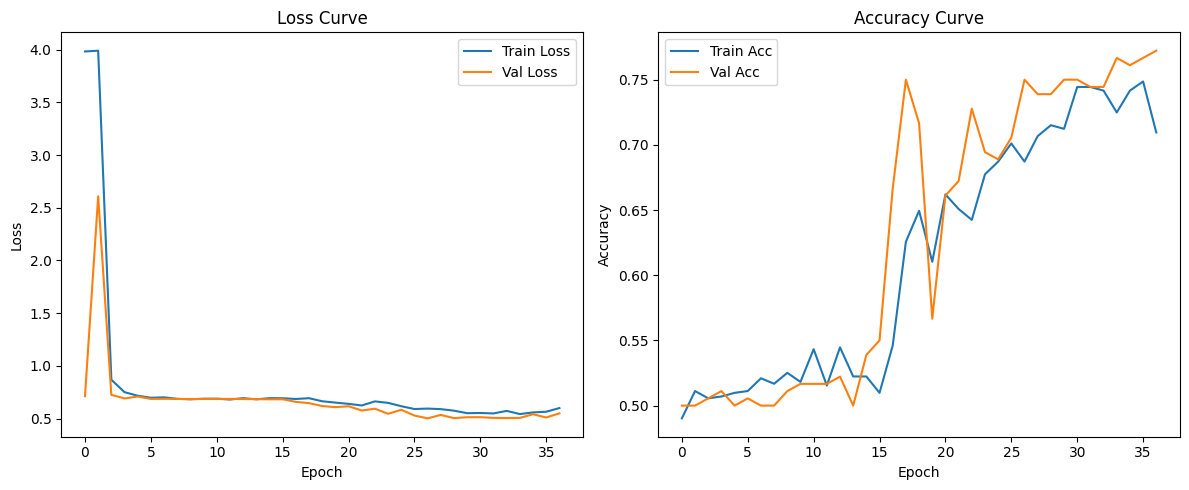

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(logs['train_loss'], label='Train Loss')
plt.plot(logs['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['train_acc'], label='Train Acc')
plt.plot(logs['val_acc'], label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# test _ f1, accuracy , 위의 함수를 호출
from sklearn.metrics import f1_score, accuracy_score
import torch

def evaluate_model(model, test_loader, checkpoint_path, device):
    """
    모델을 평가하고 Test Set 기준 Accuracy와 F1 Score를 반환하는 함수.

    Args:
        model: PyTorch 모델
        test_loader: Test DataLoader
        checkpoint_path: 저장된 모델 파라미터(.pth 파일) 경로
        device: "cuda" or "cpu"

    Returns:
        acc (float): Accuracy
        f1 (float): F1 Score
    """
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    preds_all, targets_all = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = (outputs > 0.5).float()
            preds_all.append(preds.cpu())
            targets_all.append(y.cpu())

    preds_cat = torch.cat(preds_all)
    targets_cat = torch.cat(targets_all)

    acc = accuracy_score(targets_cat, preds_cat)
    f1 = f1_score(targets_cat, preds_cat)

    print(f"Test Accuracy: {acc:.4f}, Test F1 Score: {f1:.4f}")
    return acc, f1

model = PlainCNN().to(device)
acc, f1 = evaluate_model(model, test_loader, "checkpoints/Improved_CNN_best.pth", device)

Test Accuracy: 0.6830, Test F1 Score: 0.7300


# 문제 2


## 문제 2-0
- *Bottleneck block에 대해서 구조, 동작원리, 장점을 간략히 요약 설명을 `보고서에 작성`하시오*.

## 문제 2-1

- BottleNeck block을 직접 구현하고 ResNet50 모델을 작성하시오.
- skip connection에 해당하는 부분의 코드를 찾아 보고서에 작성하고 설명하시오.
- early stopping을 사용하여 overfitting을 방지하고, learning curve를 시각화하시오.

### Resnet 50 구조

- Plain CNN과 동일하게 Conv1은 Conv - BatchNorm - Relu 구조로 구성됨

<br>
<br>

| Stage | Layer (Block 이름)      | Output Size | Kernel Size / Stride | Channels       | Blocks | Skip Connection |
| ----- | --------------------- | ----------- | -------------------- | -------------- | ------ | --------------- |
| 0     | Conv1                 | 112×112     | 7×7 / 2              | 64             | 1      | 없음              |
|       | MaxPool               | 56×56       | 3×3 / 2              | 64             | -      | -               |
| 1     | Conv2 (Bottleneck) | 56×56       | 1×1 → 3×3 → 1×1      | 64, 64, 256    | 3      | 있음 (각 블록)       |
| 2     | Conv3 (Bottleneck) | 28×28       | 1×1 → 3×3 → 1×1      | 128, 128, 512  | 4      | 있음 (각 블록)       |
| 3     | Conv4 (Bottleneck) | 14×14       | 1×1 → 3×3 → 1×1      | 256, 256, 1024 | 6      | 있음 (각 블록)       |
| 4     | Conv5 (Bottleneck) | 7×7         | 1×1 → 3×3 → 1×1      | 512, 512, 2048 | 3      | 있음 (각 블록)       |
| 5     | Average Pooling       | 2048         | AdaptiveAvgPool2d    | 2048           | -      | -               |
| 6     | Fully Connected 1  | 2048 → 1024         | -                    | 1024   | 1      | 없음              |
| 7     | Fully Connected 2  | 1024 → 128         | -                    | 1024   | 1      | 없음              |
| 8     | Fully Connected 3  | 128 → 1         | -                    | 1024   | 1      | 없음              |

<br>

### Bottleneck 구조

| Layer | Type                     | Output Channels | Kernel Size / Stride     |
| ----- | ------------------------ | --------------- | ------------------------ |
| 1     | Conv + BN + ReLU             | `planes`        | 1×1 / ?                  |
| 2     | Conv + BN + ReLU               | `planes`        | 3×3 / ?             |
| 3     | Conv + BN             | `planes × 4`    | 1×1 / ?                  |
| Skip  | Identity (or Conv1x1 + BN) + ReLU | `planes × 4`    | 1×1 / 2 (if needed) |



In [24]:
# get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
# 문제 2(1) ― Bottleneck Block 구현
# ------------------------------------------------------------
class Bottleneck(nn.Module):
    expansion = 4  # 마지막 conv에서 out_channels가 4배로 증가

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [26]:
# ------------------------------------------------------------
# 문제 2(2) ― ResNet 구현
# ------------------------------------------------------------
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)   # Conv2_x
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # Conv3_x
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # Conv4_x
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # Conv5_x

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Sequential(
            nn.Linear(512 * block.expansion, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(128, 1)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, planes, stride))
        self.in_channels = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)   # Conv1
        x = self.maxpool(x) # MaxPool

        x = self.layer1(x)  # Conv2_x
        x = self.layer2(x)  # Conv3_x
        x = self.layer3(x)  # Conv4_x
        x = self.layer4(x)  # Conv5_x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

In [27]:
def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=1)

MyResNet50 = ResNet50()
MyResNet50.cuda()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

In [45]:
# train _ early stopping (5), 위의 함수를 호출
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()
model = ResNet50().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
Cosine_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   model ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss = test(val_loader , model , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict() , "checkpoints/ResNet50_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , model , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 0.7749 , train_acc:0.5726     val_loss = 9.8817 , val_acc:0.6278     learning rate: 0.0009755282581475768


  1%|          | 1/100 [00:06<11:08,  6.76s/it]

epoch:1     train_loss = 0.6169 , train_acc:0.6913     val_loss = 0.8155 , val_acc:0.3944     learning rate: 0.0009045084971874736


  2%|▏         | 2/100 [00:13<11:12,  6.86s/it]

epoch:2     train_loss = 0.6139 , train_acc:0.6620     val_loss = 0.5258 , val_acc:0.7278     learning rate: 0.0007938926261462366


  4%|▍         | 4/100 [00:27<10:56,  6.84s/it]

epoch:3     train_loss = 0.5899 , train_acc:0.7123     val_loss = 0.5436 , val_acc:0.7389     learning rate: 0.0006545084971874737


  5%|▌         | 5/100 [00:34<10:42,  6.76s/it]

epoch:4     train_loss = 0.5754 , train_acc:0.7207     val_loss = 0.5559 , val_acc:0.7444     learning rate: 0.0005
epoch:5     train_loss = 0.5499 , train_acc:0.7360     val_loss = 0.5145 , val_acc:0.7556     learning rate: 0.00034549150281252633


  7%|▋         | 7/100 [00:47<10:25,  6.73s/it]

epoch:6     train_loss = 0.5583 , train_acc:0.7444     val_loss = 0.5369 , val_acc:0.7278     learning rate: 0.0002061073738537635


  8%|▊         | 8/100 [00:54<10:15,  6.69s/it]

epoch:7     train_loss = 0.5541 , train_acc:0.7304     val_loss = 0.5218 , val_acc:0.7722     learning rate: 9.549150281252634e-05
epoch:8     train_loss = 0.5343 , train_acc:0.7458     val_loss = 0.5056 , val_acc:0.7556     learning rate: 2.4471741852423235e-05


  9%|▉         | 9/100 [01:00<10:08,  6.68s/it]

epoch:9     train_loss = 0.5291 , train_acc:0.7402     val_loss = 0.5042 , val_acc:0.7611     learning rate: 0.0


 10%|█         | 10/100 [01:07<10:14,  6.83s/it]

epoch:10     train_loss = 0.5317 , train_acc:0.7430     val_loss = 0.5030 , val_acc:0.7611     learning rate: 2.4471741852423235e-05


 11%|█         | 11/100 [01:14<10:06,  6.82s/it]

epoch:11     train_loss = 0.5231 , train_acc:0.7486     val_loss = 0.5003 , val_acc:0.7500     learning rate: 9.549150281252665e-05


 12%|█▏        | 12/100 [01:21<09:59,  6.81s/it]

epoch:12     train_loss = 0.5330 , train_acc:0.7486     val_loss = 0.4999 , val_acc:0.7389     learning rate: 0.0002061073738537643


 14%|█▍        | 14/100 [01:35<09:49,  6.85s/it]

epoch:13     train_loss = 0.5353 , train_acc:0.7486     val_loss = 0.5099 , val_acc:0.7167     learning rate: 0.0003454915028125278


 15%|█▌        | 15/100 [01:41<09:34,  6.75s/it]

epoch:14     train_loss = 0.5321 , train_acc:0.7374     val_loss = 0.5236 , val_acc:0.7778     learning rate: 0.0005000000000000022


 16%|█▌        | 16/100 [01:48<09:23,  6.71s/it]

epoch:15     train_loss = 0.5395 , train_acc:0.7304     val_loss = 0.5186 , val_acc:0.7500     learning rate: 0.0006545084971874766


 17%|█▋        | 17/100 [01:55<09:16,  6.71s/it]

epoch:16     train_loss = 0.5559 , train_acc:0.7374     val_loss = 0.5447 , val_acc:0.7444     learning rate: 0.00079389262614624
epoch:17     train_loss = 0.5797 , train_acc:0.7137     val_loss = 0.5119 , val_acc:0.7667     learning rate: 0.0009045084971874779


 17%|█▋        | 17/100 [02:02<09:59,  7.23s/it]

Early stop !
0.6964285714285714


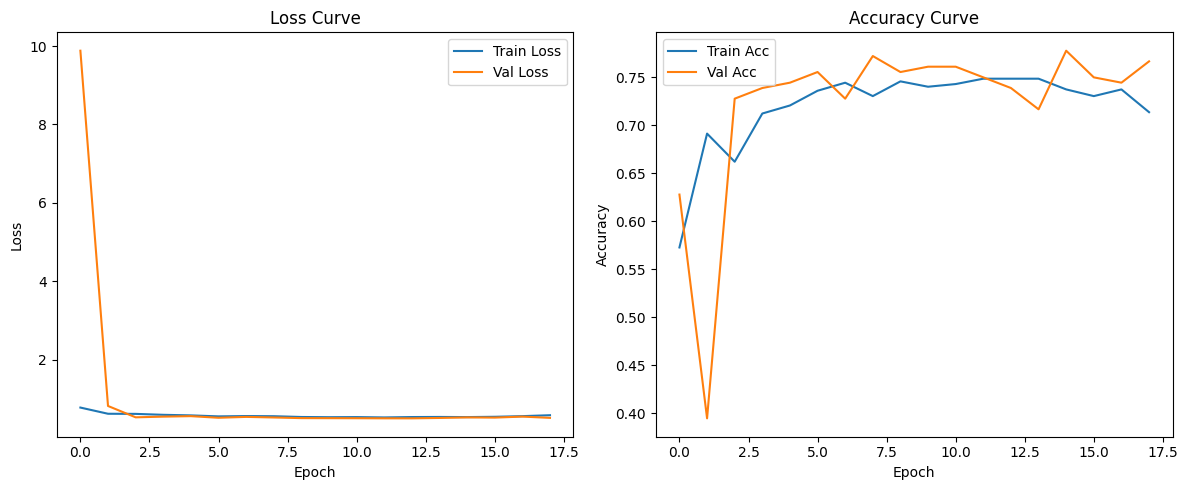

In [46]:
# learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(logs['train_loss'], label='Train Loss')
plt.plot(logs['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['train_acc'], label='Train Acc')
plt.plot(logs['val_acc'], label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# test _ f1, accuracy , 위의 함수를 호출

from sklearn.metrics import f1_score, accuracy_score
import torch

model = ResNet50().to(device)
acc, f1 = evaluate_model(model, test_loader, "checkpoints/ResNet50_best.pth", device)

Test Accuracy: 0.7232, Test F1 Score: 0.7578


## 문제 3: Pretrained Model (backbone) 학습

- 아래의 `vgg16` 예제를 참고하여, `resnet50`의 pretrained model를 불러와 **2개의 모델**을 구현 및 학습 후 최종 성능을 도출하시오.



| 항목                         | CNN\_Frozen Model (pt_fixed)                              | BatchNorm Activate Model (pt_partial)                 |
| -------------------------- | ---------------------------------------------- | ---------------------------------------- |
| 사용 모델                      | `torchvision.models.resnet50(pretrained=True)` | 동일                                       |
| Frozen 대상                  | **모든** CNN layer (Conv + BN 포함)                | Conv 계층만 frozen, **BN 계층은 학습 가능**        |
| `.requires_grad = True` 대상 | 없음 (`fc`만 따로 학습 가능하게 설정)                       | **BatchNorm 계층 파라미터**만 True로 설정          |
| 모델 클래스 이름                  | `resnet_pretrained`                            | `resnet_pretrained_bn_trainable` (예시 이름) |

<br>
<br>

- 기존 사전 학습된 Resnet50의 `마지막 `Fully Connected`는 제외하고 불러와야 합니다.
- `MyResNet50`의 Fc layer와 동일한 size로 작성하세요. (아래 표 참고)


| Stage | Layer (Block 이름)   | Output Size   |
|-------|---------------------|---------------|
| 0     | `resnet_pretrained` | 2048          |
| 1     | Fully Connected 1   | 2048 → 1024   |
| 2     | Fully Connected 2   | 1024 → 128    |
| 3     | Fully Connected 3   | 128 → 1       |

<br>



- **최소 test acc (80%) 이상 달성**

In [31]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

# pretrained model 불러오는 예시
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
# pretrained ResNet50 불러오기
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50Pretrained(nn.Module):
    """
    train_bn_fc_only = False  → 모든 파라미터 freeze, fc만 학습
    train_bn_fc_only = True   → BN + fc는 학습, 나머지는 freeze
    """

    def __init__(self, num_classes: int = 1, train_bn_fc_only: bool = False):
        super().__init__()

        # 1. Pretrained resnet50 불러오기 (FC 제외)
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # conv1 ~ layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 2. FC layers
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # 3. freeze 설정
        self._configure_trainable_layers(train_bn_fc_only)

    def _configure_trainable_layers(self, train_bn_fc_only: bool) -> None:
        # 모든 backbone 파라미터 비활성화
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False

        if train_bn_fc_only:
            # BN만 활성화
            for module in self.backbone.modules():
                if isinstance(module, nn.BatchNorm2d):
                    for p in module.parameters():
                        p.requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)       # feature extractor
        x = self.avgpool(x)        # global avg pooling
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return torch.sigmoid(x)    # binary classification용

In [34]:
pt_fixed = ResNet50Pretrained(train_bn_fc_only=False)
pt_partial = ResNet50Pretrained(train_bn_fc_only=True)

In [48]:
# train _ early stopping (5), 위의 함수를 호출


def train_with_early_stopping(model_name: str, model, train_loader, val_loader, test_loader):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    criterion = nn.BCELoss()

    EPOCHS = 100
    patience = 10
    counter = 0
    best_loss = np.inf
    logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")

    for epoch in tqdm(range(EPOCHS)):
        train_acc, train_loss = train(train_loader, model, criterion, optimizer, scheduler)
        val_acc, val_loss = test(val_loader, model, criterion)

        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)

        print(f"[{model_name}] Epoch {epoch} | train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), f"checkpoints/{model_name}_best.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"[{model_name}] Early stopping.")
                break

    # 최종 성능 평가
    model.load_state_dict(torch.load(f"checkpoints/{model_name}_best.pth"))
    test_acc, test_loss= test(test_loader, model, criterion)
    print(f"[{model_name}] Test Accuracy: {test_acc:.4f}")
    return test_acc

pt_fixed = ResNet50Pretrained(train_bn_fc_only=False).to(device)
pt_partial = ResNet50Pretrained(train_bn_fc_only=True).to(device)

results = {}

results["pt_fixed"] = train_with_early_stopping("pt_fixed", pt_fixed, train_loader, val_loader, test_loader)
results["pt_partial"] = train_with_early_stopping("pt_partial", pt_partial, train_loader, val_loader, test_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

[pt_fixed] Epoch 0 | train_loss=0.5219, val_loss=0.2404, val_acc=0.8722


  1%|          | 1/100 [00:06<09:55,  6.02s/it]

[pt_fixed] Epoch 1 | train_loss=0.3651, val_loss=0.2088, val_acc=0.9111


  2%|▏         | 2/100 [00:12<09:56,  6.09s/it]

[pt_fixed] Epoch 2 | train_loss=0.2198, val_loss=0.1657, val_acc=0.9167


  4%|▍         | 4/100 [00:24<09:35,  6.00s/it]

[pt_fixed] Epoch 3 | train_loss=0.1515, val_loss=0.2021, val_acc=0.9278


  5%|▌         | 5/100 [00:29<09:22,  5.92s/it]

[pt_fixed] Epoch 4 | train_loss=0.1434, val_loss=0.2456, val_acc=0.9222


  6%|▌         | 6/100 [00:35<09:06,  5.81s/it]

[pt_fixed] Epoch 5 | train_loss=0.1025, val_loss=0.1907, val_acc=0.9222


  7%|▋         | 7/100 [00:41<08:57,  5.78s/it]

[pt_fixed] Epoch 6 | train_loss=0.0719, val_loss=0.2288, val_acc=0.9222


  8%|▊         | 8/100 [00:46<08:48,  5.75s/it]

[pt_fixed] Epoch 7 | train_loss=0.0617, val_loss=0.1781, val_acc=0.9278


  9%|▉         | 9/100 [00:52<08:39,  5.71s/it]

[pt_fixed] Epoch 8 | train_loss=0.0554, val_loss=0.1996, val_acc=0.9333


 10%|█         | 10/100 [00:58<08:34,  5.71s/it]

[pt_fixed] Epoch 9 | train_loss=0.0393, val_loss=0.1842, val_acc=0.9278


 11%|█         | 11/100 [01:03<08:24,  5.67s/it]

[pt_fixed] Epoch 10 | train_loss=0.0405, val_loss=0.1828, val_acc=0.9278


 12%|█▏        | 12/100 [01:09<08:19,  5.68s/it]

[pt_fixed] Epoch 11 | train_loss=0.0356, val_loss=0.2004, val_acc=0.9333


 12%|█▏        | 12/100 [01:15<09:10,  6.26s/it]

[pt_fixed] Epoch 12 | train_loss=0.0769, val_loss=0.2083, val_acc=0.9333
[pt_fixed] Early stopping.


[pt_fixed] Test Accuracy: 0.9509


  0%|          | 0/100 [00:00<?, ?it/s]

[pt_partial] Epoch 0 | train_loss=0.5233, val_loss=0.2266, val_acc=0.9000


  1%|          | 1/100 [00:06<10:45,  6.52s/it]

[pt_partial] Epoch 1 | train_loss=0.2656, val_loss=0.1598, val_acc=0.9111


  2%|▏         | 2/100 [00:13<10:47,  6.61s/it]

[pt_partial] Epoch 2 | train_loss=0.1582, val_loss=0.1437, val_acc=0.9444


  4%|▍         | 4/100 [00:26<10:38,  6.65s/it]

[pt_partial] Epoch 3 | train_loss=0.1557, val_loss=0.1535, val_acc=0.9389


  5%|▌         | 5/100 [00:32<10:19,  6.52s/it]

[pt_partial] Epoch 4 | train_loss=0.0886, val_loss=0.1506, val_acc=0.9389


  6%|▌         | 6/100 [00:39<10:07,  6.46s/it]

[pt_partial] Epoch 5 | train_loss=0.0437, val_loss=0.1693, val_acc=0.9389


  7%|▋         | 7/100 [00:45<09:56,  6.42s/it]

[pt_partial] Epoch 6 | train_loss=0.0503, val_loss=0.1481, val_acc=0.9444


  8%|▊         | 8/100 [00:51<09:42,  6.33s/it]

[pt_partial] Epoch 7 | train_loss=0.0247, val_loss=0.1808, val_acc=0.9389


  9%|▉         | 9/100 [00:57<09:30,  6.27s/it]

[pt_partial] Epoch 8 | train_loss=0.0271, val_loss=0.1918, val_acc=0.9333


 10%|█         | 10/100 [01:04<09:25,  6.28s/it]

[pt_partial] Epoch 9 | train_loss=0.0218, val_loss=0.1778, val_acc=0.9333


 11%|█         | 11/100 [01:10<09:22,  6.32s/it]

[pt_partial] Epoch 10 | train_loss=0.0202, val_loss=0.1792, val_acc=0.9389


 12%|█▏        | 12/100 [01:17<09:27,  6.45s/it]

[pt_partial] Epoch 11 | train_loss=0.0300, val_loss=0.1944, val_acc=0.9389


 12%|█▏        | 12/100 [01:23<10:13,  6.97s/it]

[pt_partial] Epoch 12 | train_loss=0.0181, val_loss=0.1764, val_acc=0.9389
[pt_partial] Early stopping.


[pt_partial] Test Accuracy: 0.9464


In [52]:
from sklearn.metrics import f1_score, accuracy_score
import torch

model = pt_fixed
acc, f1 = evaluate_model(model, test_loader, "checkpoints/pt_fixed_best.pth", device)

Test Accuracy: 0.9509, Test F1 Score: 0.9520


In [53]:
from sklearn.metrics import f1_score, accuracy_score
import torch

model = pt_partial
acc, f1 = evaluate_model(model, test_loader, "checkpoints/pt_partial_best.pth", device)

Test Accuracy: 0.9464, Test F1 Score: 0.9474


#최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (Plain CNN, MyResnet,pt_fixed,pt_partial)

``` python
# load trained model parameters
model_state_dict = torch.load(" ")
PlainCNN = PlainCNN()
PlainCNN.load_state_dict(model_state_dict)

```

In [36]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_model_on_test_set(model, model_name, checkpoint_path, test_loader):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    preds_all, targets_all = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = (outputs > 0.5).float()
            preds_all.append(preds.cpu())
            targets_all.append(y.cpu())

    y_pred = torch.cat(preds_all)
    y_true = torch.cat(targets_all)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"[{model_name}] Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return acc, f1

In [49]:
# plain = PlainCNN()
# resnet = ResNet()
# pt_fixed = ResNet50Pretrained(train_bn_fc_only=False)
# pt_partial = ResNet50Pretrained(train_bn_fc_only=True)

model = pt_fixed  # 또는 pt_partial
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

results = {}

# 모델 정의 및 학습
plain = PlainCNN().to(device)
resnet = ResNet50().to(device)
pt_fixed = ResNet50Pretrained(train_bn_fc_only=False).to(device)
pt_partial = ResNet50Pretrained(train_bn_fc_only=True).to(device)

# 성능 평가
results["plain"] = evaluate_model_on_test_set(plain, "plain", "checkpoints/Improved_CNN_best.pth", test_loader)
results["resnet"] = evaluate_model_on_test_set(resnet, "resnet", "checkpoints/ResNet50_best.pth", test_loader)
results["pt_fixed"] = evaluate_model_on_test_set(pt_fixed, "pt_fixed", "checkpoints/pt_fixed_best.pth", test_loader)
results["pt_partial"] = evaluate_model_on_test_set(pt_partial, "pt_partial", "checkpoints/pt_partial_best.pth", test_loader)


[plain] Test Accuracy: 0.6830, F1 Score: 0.7300
[resnet] Test Accuracy: 0.7232, F1 Score: 0.7578
[pt_fixed] Test Accuracy: 0.9509, F1 Score: 0.9520
[pt_partial] Test Accuracy: 0.9464, F1 Score: 0.9474


수고하셨습니다!